In [18]:
!pip install --upgrade pip
!pip install --upgrade efficientnet
!pip install -U scikit-image
!pip install -U keras-tqdm

Requirement already up-to-date: pip in /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages (20.1.1)
Requirement already up-to-date: efficientnet in /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages (1.1.0)
Requirement already up-to-date: scikit-image in /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages (0.17.2)


In [2]:
from efficientnet.keras import EfficientNetB3

Using TensorFlow backend.


In [3]:
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Activation, Dropout, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, applications
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras import backend as K 

In [4]:
train_dir = './train/train'
train_resize_dir = './train/resize_300_train'
#train_dir_cats = './kaggle_dogcat/train/cats'
test_dir = './test/test/'
test_resize_dir = './test/resize_300_test'

df = pd.read_csv('resize_300.csv', dtype=str)  
df_test = pd.read_csv('test.csv', dtype=str)
df['filename_resize'] = train_resize_dir +'/'+ df['category'] +'/'+ df['filename']
df['filename_oringal'] = train_dir +'/'+ df['category'] +'/'+ df['filename']
df_test.head()

filename category
0  fd663cf2b6e1d7b02938c6aaae0a32d2.jpg       43
1  c7fd77508a8c355eaab0d4e10efd6b15.jpg       43
2  127f3e6d6e3491b2459812353f33a913.jpg       43
3  5ca4f2da11eda083064e6c36f37eeb81.jpg       43
4  46d681a542f2c71be017eef6aae23313.jpg       43

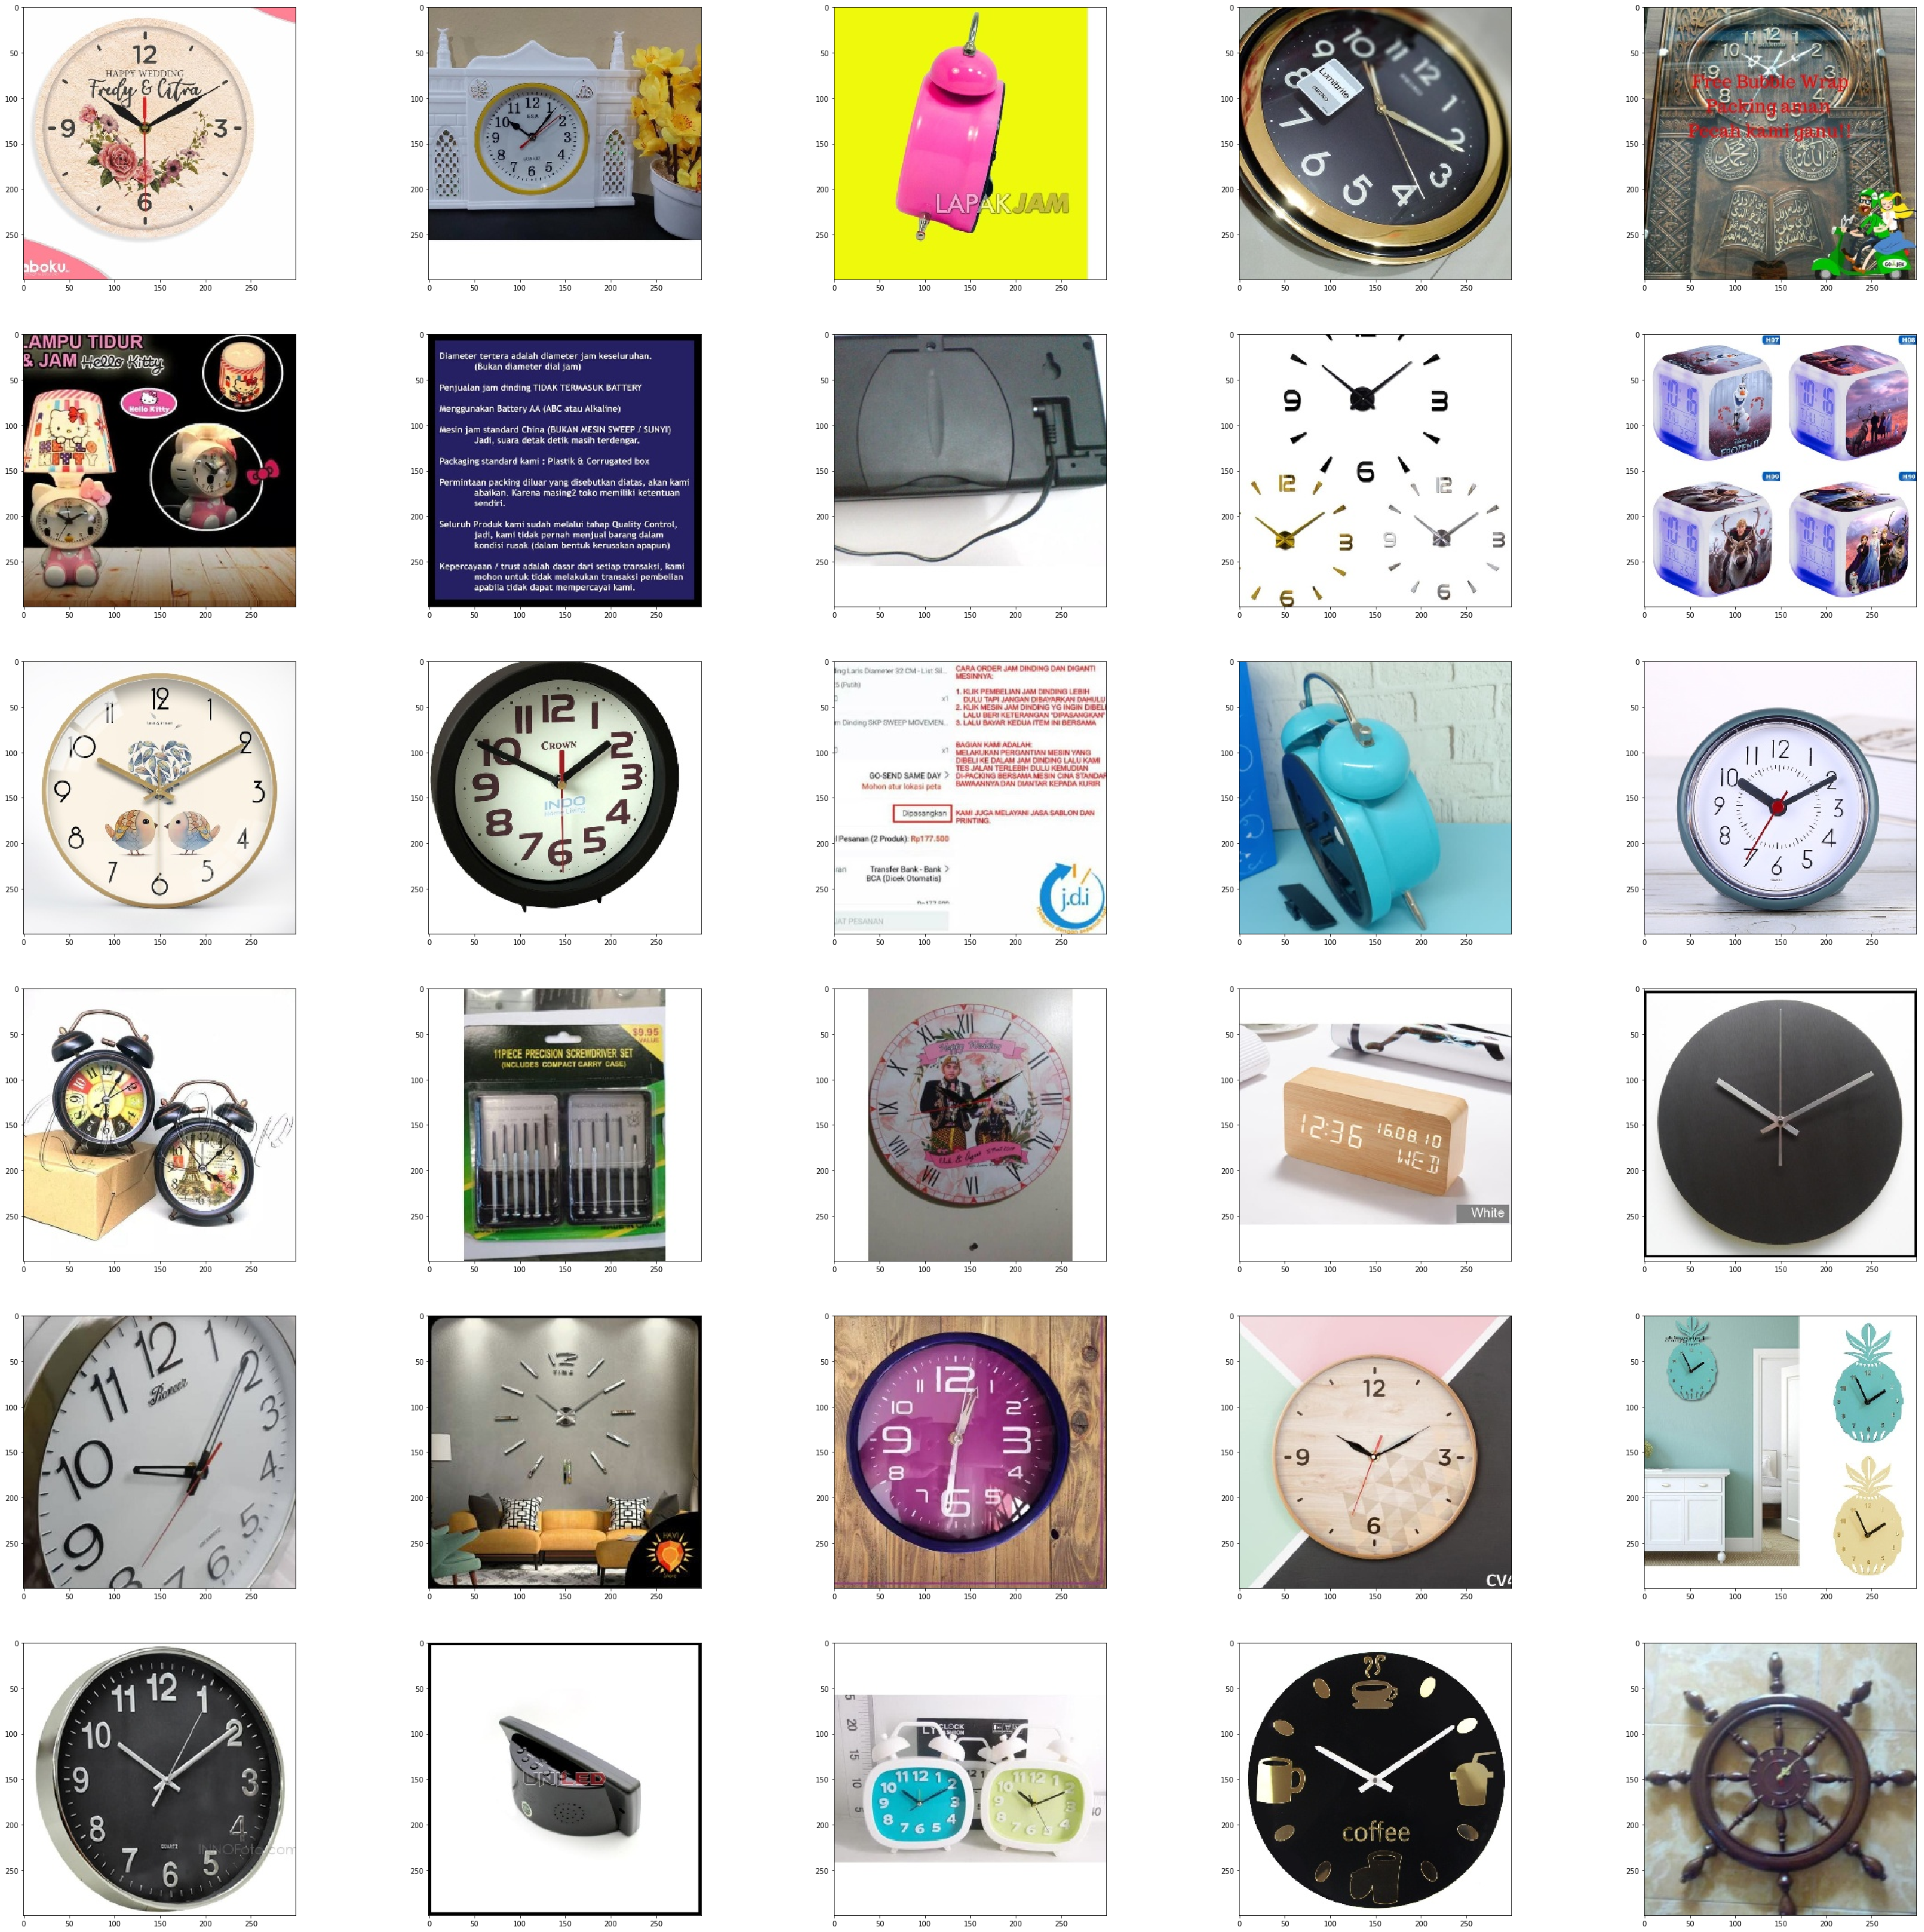

In [44]:
# Example of images for category = 
img_names = df[df['category']=='12']['filename_resize'][:30]
#print(img_names)
plt.figure(figsize=[50,50])
i = 1
for img_name in img_names:
    img = cv2.imread(img_name)[...,[2, 1, 0]]
    plt.subplot(6, 5, i)
    plt.imshow(img)
    i += 1
plt.show()

In [6]:
traindf = pd.read_csv('train.csv', dtype=str)  
traindf.head()

filename category
0  45e2d0c97f7bdf8cbf3594beb6fdcda0.jpg       03
1  f74d1a5fc2498bbbfa045c74e3cc333e.jpg       03
2  f6c172096818c5fab10ecae722840798.jpg       03
3  251ffd610399ac00fea7709c642676ee.jpg       03
4  73c7328b8eda399199fdedec6e4badaf.jpg       03

In [70]:
%%time
from keras.preprocessing.image import ImageDataGenerator
image_size = 200
batch_size = 16

gen =  ImageDataGenerator(
    rescale=1/255,
    validation_split=0.2,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_iter=gen.flow_from_dataframe( dataframe=traindf, directory="./train/train_300_all", x_col="filename", y_col="category", batch_size=batch_size,
                                   has_ext=False, subset="training", class_mode="categorical", target_size=(image_size,image_size)) 
valid_iter=gen.flow_from_dataframe( dataframe=traindf, directory="./train/train_300_all", x_col="filename", y_col="category", batch_size=batch_size,
                                   has_ext=False, subset="validation", class_mode="categorical",target_size=(image_size,image_size))


Found 84314 validated image filenames belonging to 42 classes.
Found 21078 validated image filenames belonging to 42 classes.
CPU times: user 1.3 s, sys: 248 ms, total: 1.54 s
Wall time: 1.54 s


In [71]:
!pip install tqdm

In [72]:
nb_classes = 42

In [73]:
model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

In [74]:
model.trainable = False

In [75]:
#Adding custom layers 
x = model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(nb_classes, activation="softmax")(x)
model_final = Model(input = model.input, output = predictions)
model_final.summary()
model_final.compile(optimizers.rmsprop(lr=0.0001, decay=1e-6),loss='categorical_crossentropy',metrics=['accuracy'])

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 200, 200, 3)  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 100, 100, 40) 1080        input_5[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 100, 100, 40) 160         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 100, 100, 40) 0           stem_bn[0][0]                    
__________________________________________________________________________________________________
block1a_dw

In [ ]:
%%time
# Train model
n_steps = 84314 // batch_size
history = model_final.fit_generator(
    train_iter,
    epochs = 5,
    steps_per_epoch = n_steps,
    validation_data = valid_iter,
    validation_steps = 7,
    use_multiprocessing=True,
    workers=4,
)

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/5
4602/5269 [=========================>....] - ETA: 7:02 - loss: 0.4764 - acc: 0.8968

In [ ]:
with open('history.json', 'w') as f:
    json.dump(history.history, f)

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['acc', 'val_acc']].plot()

In [ ]:
df_test = pd.read_csv('./test.csv')
X_test = []
for imageName in df_test['filename']: 
    #print(test_dir + imageName)
    image = cv2.imread(test_dir + imageName)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (image_size, image_size))
    X_test.append(image)
X_test = np.array(X_test).astype('float16')/255

In [ ]:
res = model_final.predict(X_test, batch_size=batch_size)

In [ ]:
res.shape

In [ ]:
df_test['category'].shape

In [ ]:
res = np.argmax(res, axis=1)
df_test['category'] = res

df_test['category'] = df.category.apply(lambda c: str(c).zfill(2))
#print (df_test['category'])
df_test.to_csv('output.csv', index = False)